In [2]:
import os
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from dataloader import get_dataloaders
from helpers import (
    custom_target_transform,
    decode_segmap,
    load_config,
    load_images,
    visualize_dataloader,
    visualize_predictions,
)
from model import SegmentationModel

In [4]:
project_dir_path = os.path.abspath('')

# Load params from JSON file
config = load_config(os.path.join(project_dir_path, "config.json"))

# Use parameters from the config file
general_config = config["general"]
DEV_RUN = general_config.get("DEV_RUN", False)
IN_CHANNELS = general_config.get("IN_CHANNELS", 3)
BATCH_SIZE = general_config.get("BATCH_SIZE", 4)
EPOCHS = general_config.get("EPOCHS", 20)
LEARNING_RATE = general_config.get("LEARNING_RATE", 1e-5)
RESOLUTION = general_config.get("RESOLUTION", 1024)
PIN_MEMORY = general_config.get("PIN_MEMORY", False)
WORKERS = general_config.get("WORKERS", 0)
NAME = general_config.get("NAME", "DeepLabV3Plus50")
CHECKPOINT_NAME = general_config.get("CHECKPOINT_NAME", None)
CHECKPOINT_DIR = os.path.join(project_dir_path, "checkpoints", NAME)

# SMP Model parameters
smp_config = config["smp_model"]
ENCODER_NAME = smp_config.get("ENCODER_NAME", "resnet50")
ENCODER_WEIGHTS = smp_config.get("ENCODER_WEIGHTS", "imagenet")
ACTIVATION = smp_config.get("ACTIVATION", None)

In [5]:
# Load data
# Define transformations
train_transform = transforms.Compose(
    [
        transforms.Resize(
            (RESOLUTION, RESOLUTION)
        ),  # Resize images to a fixed size for training
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize with ImageNet stats
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(
            (RESOLUTION, RESOLUTION)
        ),  # Resize images to a fixed size for training
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize with ImageNet stats
    ]
)

target_transforms = transforms.Compose(
    [
        transforms.Resize(
            (RESOLUTION, RESOLUTION),
            interpolation=transforms.InterpolationMode.NEAREST,
        ),  # Resize masks without interpolation
        transforms.ToTensor(),
        custom_target_transform,
    ]
)
train_loader, val_loader = get_dataloaders(
    BATCH_SIZE,
    WORKERS,
    PIN_MEMORY,
    train_transform,
    target_transforms,
)
CLASSES_TO_PREDICT = len(train_loader.dataset.classes)

Loading data from c:\Users\Martin\Documents\GIT\NTNU\TDT17-2023\data\cityscapes
Loaded. Creating dataloaders...
Train examples: 2975
Val examples: 500


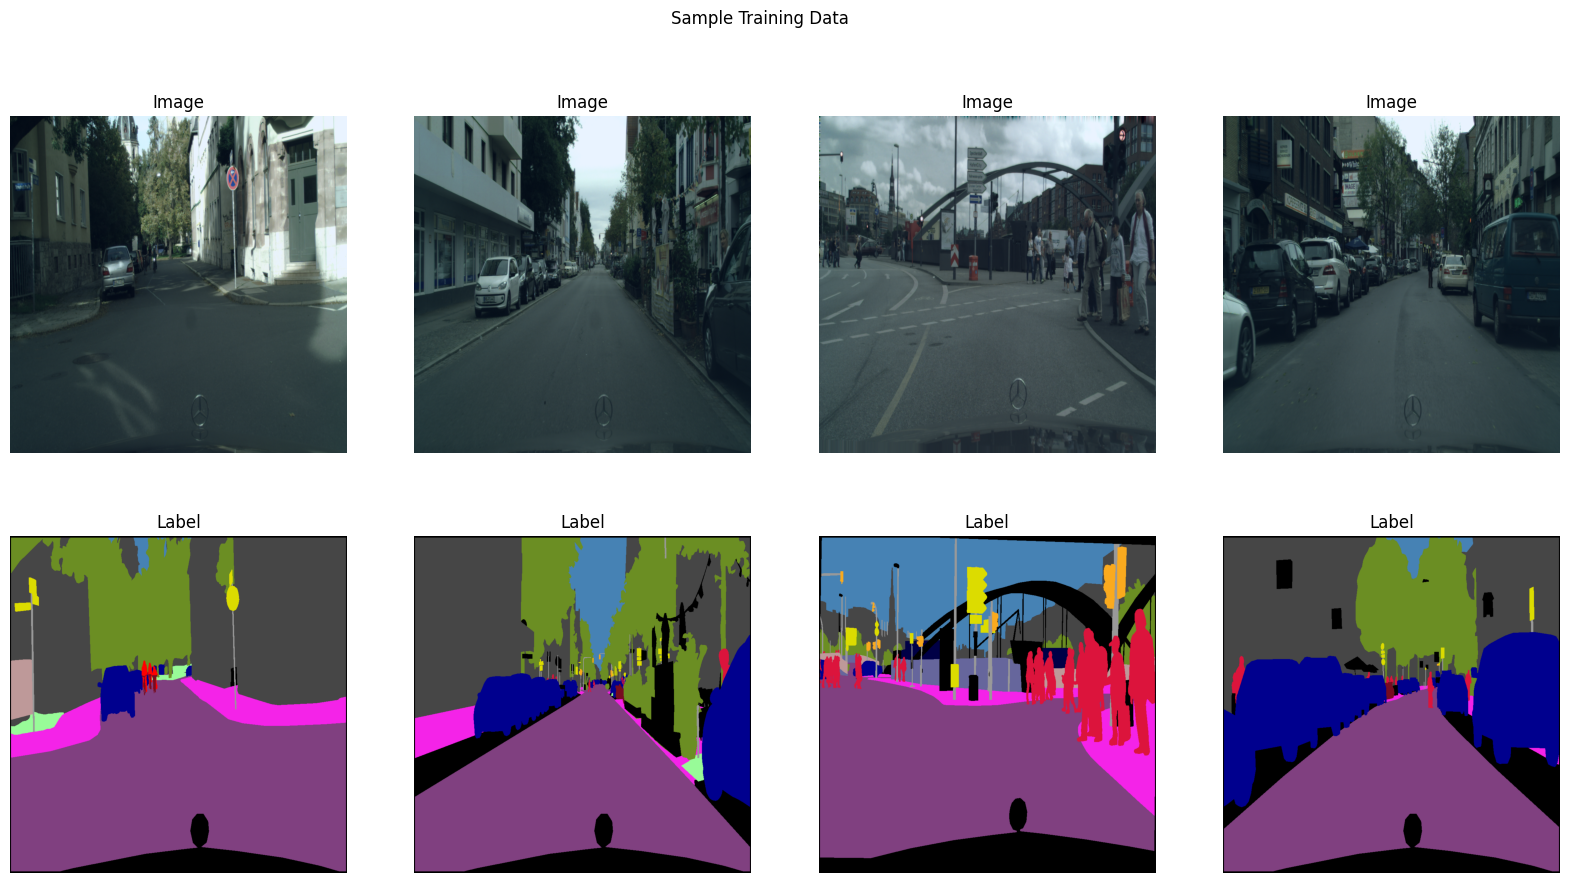

In [6]:
visualize_dataloader(train_loader)

In [7]:
# Create the segmentation model with specified encoder
smp_model = smp.DeepLabV3Plus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=IN_CHANNELS,
    classes=CLASSES_TO_PREDICT,
    activation=ACTIVATION,
)

In [10]:
# Initialize your Lightning model
model = SegmentationModel(
    model=smp_model,
    num_classes=CLASSES_TO_PREDICT,
    lr=LEARNING_RATE,
    total_steps=EPOCHS * len(train_loader),
    ignore_index=0,
)

if CHECKPOINT_NAME is None:
    print("No checkpoint specified. Showing random results.")
else:
    print("Loading checkpoint from: ", CHECKPOINT_NAME)
    model = model.load_from_checkpoint(
        os.path.join(CHECKPOINT_DIR, CHECKPOINT_NAME), model=smp_model
    )


Loading checkpoint from:  epoch=19_val_loss=0.647_val_MulticlassJaccardIndex_micro=0.300.ckpt


In [11]:
# Define callbacks
callbacks = [
    ModelCheckpoint(
        dirpath=CHECKPOINT_DIR,
        filename="{epoch}_{val_loss:.3f}_{val_MulticlassJaccardIndex_micro:.3f}",
        save_top_k=3,
        monitor="val_loss",
        mode="min",
    ),
    EarlyStopping(
        monitor="val_loss", min_delta=2e-4, patience=8, verbose=False, mode="min"
    ),
    LearningRateMonitor(logging_interval="step"),
]
logger = TensorBoardLogger(save_dir="./logs", name=NAME)

trainer = pl.Trainer(
    accelerator="gpu",
    precision=16,
    max_epochs=EPOCHS,
    fast_dev_run=DEV_RUN,
    callbacks=callbacks,
    logger=logger,
    profiler="simple",
)

c:\Users\Martin\miniconda3\envs\pytorch-nightly11\Lib\site-packages\lightning_fabric\connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.test(model=model, dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Martin\miniconda3\envs\pytorch-nightly11\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  2293          

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Runningstage.testing metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  test_MulticlassAccuracy_micro_epoch            0.8776169419288635
 test_MulticlassFBetaScore_micro_epoch           0.8776169419288635
test_MulticlassJaccardIndex_micro_epoch          0.7843020558357239
            test_loss_epoch                      0.6471807360649109
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.6471807360649109,
  'test_MulticlassAccuracy_micro_epoch': 0.8776169419288635,
  'test_MulticlassJaccardIndex_micro_epoch': 0.7843020558357239,
  'test_MulticlassFBetaScore_micro_epoch': 0.8776169419288635}]

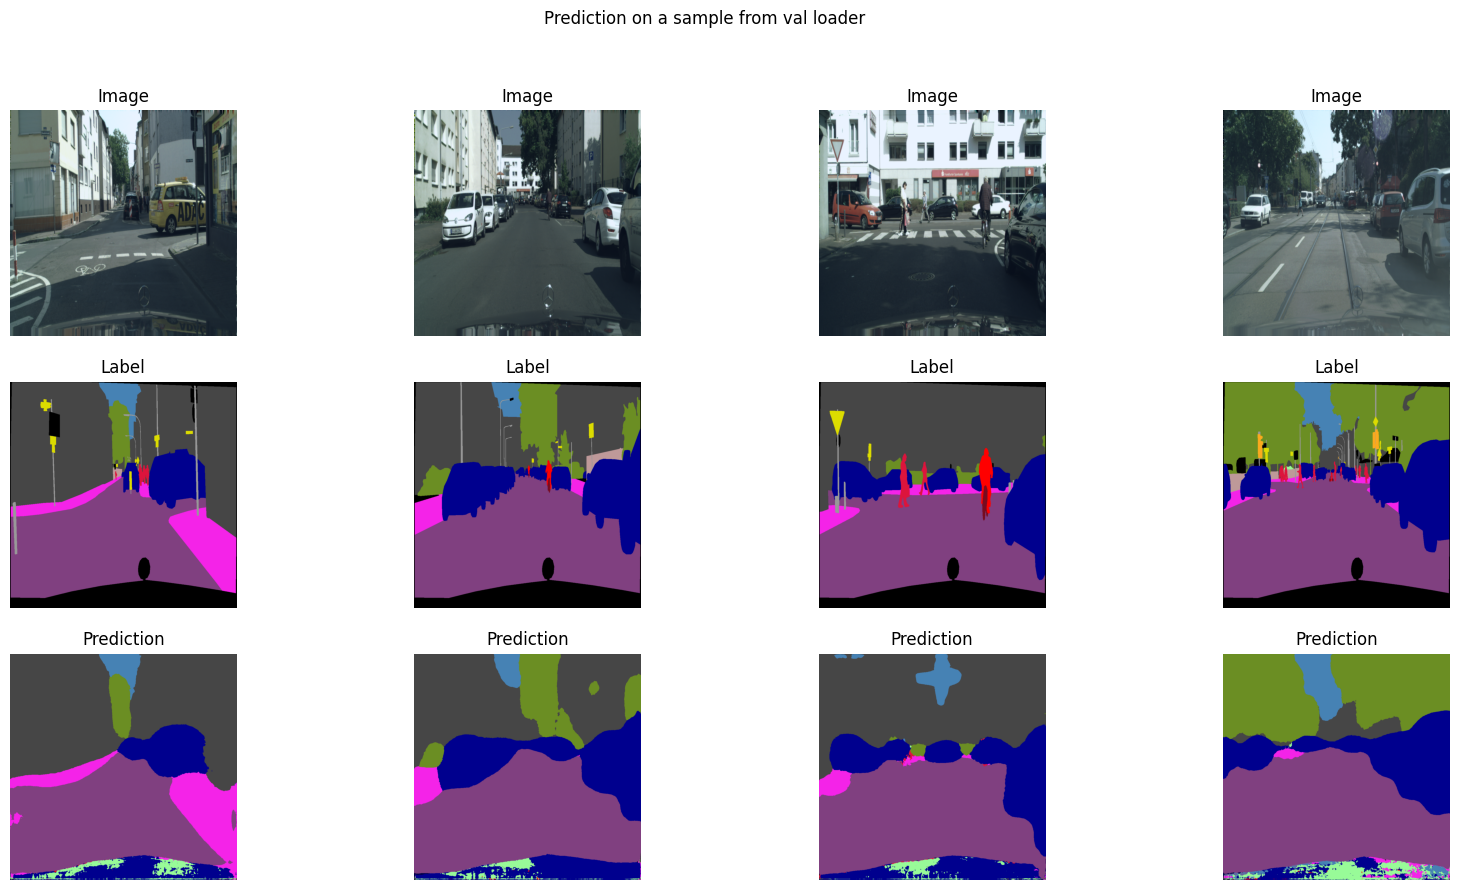

In [13]:
visualize_predictions(model, val_loader)

In [14]:
# Load images
path_to_images = os.path.join(os.path.abspath(""), "data", "trondheim")
images = load_images(path_to_images)

# Apply transforms on images and batch them
images = torch.stack([test_transform(img) for img in images], dim=0)

In [15]:
# Make a prediction using the model
model.eval()
prediction = model(images)

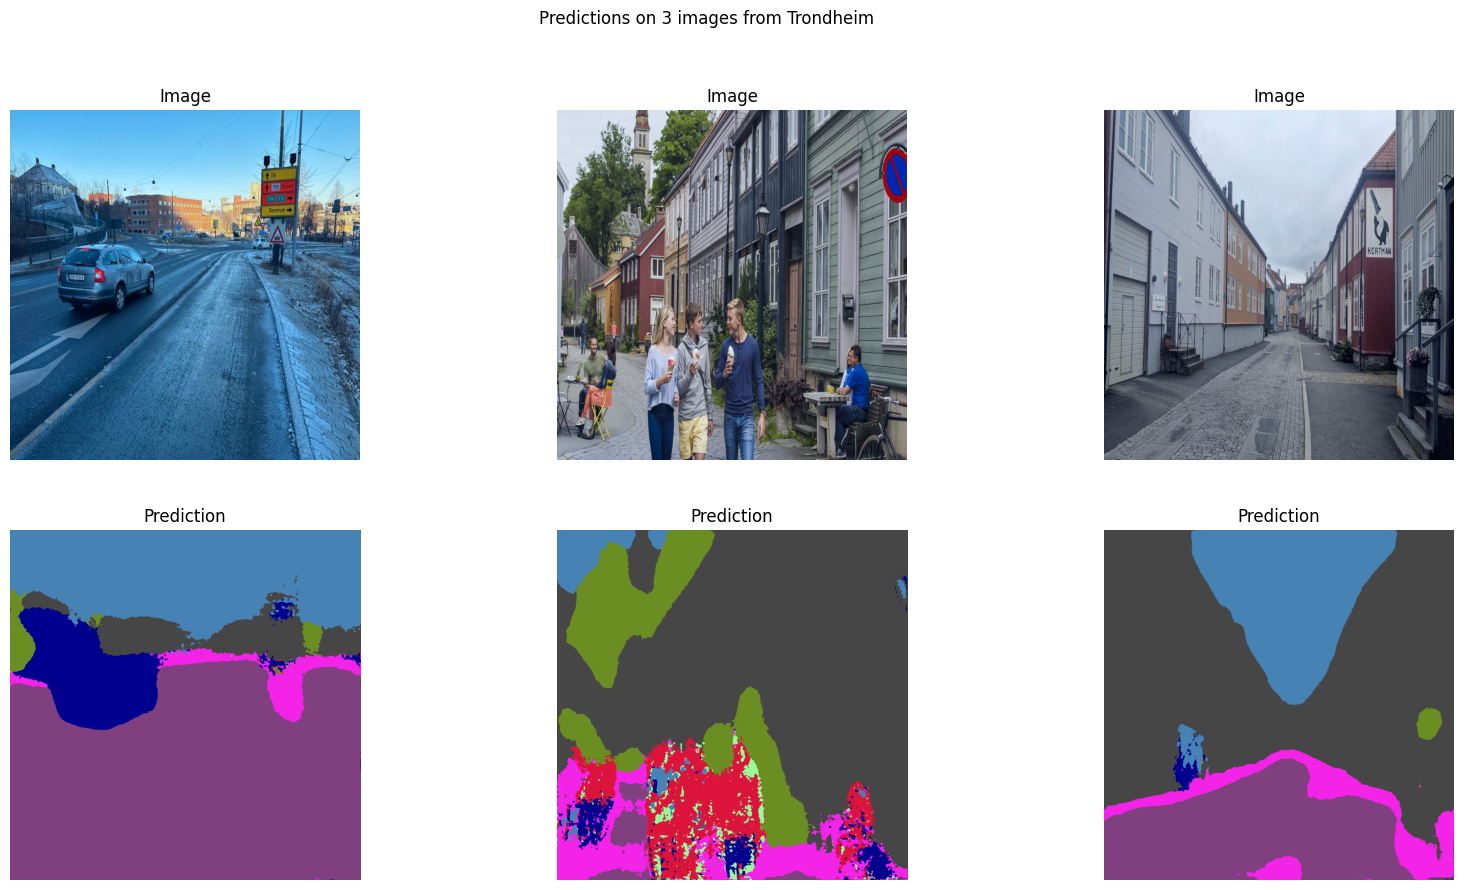

In [16]:
# Extract the color map from the train loader for visualization
color_map = train_loader.dataset.color_map

# Set up the plots
fig, axes = plt.subplots(nrows=2, ncols=len(prediction), figsize=(20, 10))
fig.suptitle("Predictions on 3 images from Trondheim")

# Plot images, labels, and predictions
for i in range(len(prediction)):
    img = images[i].numpy().transpose((1, 2, 0))  # Correcting channel order
    img = (img - img.min()) / (
        img.max() - img.min()
    )  # Normalize to 0-1 if not already

    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Image")
    axes[1, i].imshow(decode_segmap(prediction[i].argmax(axis=0), color_map))
    axes[1, i].axis("off")
    axes[1, i].set_title("Prediction")

# Show the plots
plt.show()